# Metric Final Dev

In [1]:
from brian2 import *
from brian2tools import *

prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [3]:
# Generate a step-current input and an "experimental" voltage trace
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA
input_current1 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt))*2, np.zeros(int(5*ms/dt))])*nA
input_current2 = np.stack((input_current0, input_current1))

In [4]:
Ntraces, Nsteps = np.shape(input_current2)

In [5]:
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [6]:
# The model
eqsHH = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [7]:
I = TimedArray(input_current0, dt=dt)

G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params_correct, units=False)
mon = StateMonitor(G, 'v', record=0)
run(20*ms)

voltage = mon.v[0]/mV
voltage += np.random.randn(len(voltage))


inp_trace0 = np.array([input_current0])
n0, n1 = inp_trace0.shape

out_trace0 = np.array(voltage[:n1])

In [8]:
start_scope()
I = TimedArray(input_current1, dt=dt)
G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params_correct, units=False)
mon = StateMonitor(G, 'v', record=0)

run(20*ms)

voltage = mon.v[0]/mV

voltage += np.random.randn(len(voltage))
inp_trace1 = np.array([input_current1])
n0, n1 = inp_trace1.shape
out_trace1 = np.array(voltage[:n1])

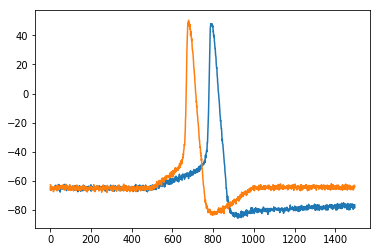

In [9]:
plot(out_trace0)
plot(out_trace1);

### Generate Proper Input Format for the Problem

In [10]:
inp_trace = np.concatenate((inp_trace0, inp_trace1))
out_trace = np.concatenate(([out_trace0], [out_trace1]))

In [11]:
inp_trace

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
# out_trace 

In [13]:
# Model for modelfitting
eqs = Equations(
'''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''',
Cm=1*ufarad*cm**-2 * area, El=-65*mV, EK=-90*mV, ENa=50*mV, VT=-63*mV)

In [14]:
n_opt = NevergradOptimizer()

In [15]:
res, error, ot, te = fit_traces_standalone(model=eqs, input_var='I', output_var='v',
                                   input=inp_trace * amp, output=out_trace*mV, dt=dt,
                                   gl=[1e-8*siemens*cm**-2 * area, 1e-3*siemens*cm**-2 * area],
                                   g_na=[1*msiemens*cm**-2 * area, 2000*msiemens*cm**-2 * area],
                                   g_kd=[1*msiemens*cm**-2 * area, 1000*msiemens*cm**-2 * area],
                                   n_rounds=2, n_samples=6, optimizer=n_opt,)


INFO       No numerical integration method specified for group 'neurongroup', using method 'exponential_euler' (took 0.17s, trying other methods took 0.13s). [brian2.stateupdaters.base.method_choice]


In [20]:
y = out_trace * 1e-3

In [21]:
errors = []


for n, nround in enumerate(ot):
    mse_list = []
    for trace in nround:
        mse = np.sum(np.square(y[n] - trace))
        mse_list.append(mse)

    mse_len = len(mse_list)    
    mse_arr = np.reshape(np.array(mse_list), (int(mse_len/Ntraces), Ntraces))
    err_out_mse = mse_arr.mean(axis=1)
    errors.append(err_out_mse)
        
errors

[array([1.24360865, 1.19929873, 1.03597812, 1.30689455, 0.92444843,
        1.05674411]),
 array([1.01789035, 1.45469862, 0.72776997, 0.76840661, 0.71263868,
        0.9299028 ])]

In [25]:
mse_list

[1.5825944119273316,
 0.45318629243765113,
 1.7140033643883534,
 1.1953938689086907,
 1.2196569194905615,
 0.23588301679891197,
 1.3390251264152546,
 0.197788097239916,
 1.0811853099269335,
 0.3440920458541188,
 1.4926950617470407,
 0.36711053548177786]

In [22]:
xx0 = np.sum(te[0], axis=1)
xx0

array([740.76290108, 769.98204854, 743.19496469, 304.23043716,
       412.36711901, 426.94963349, 853.19588638, 602.8993167 ,
       300.82057856, 338.15063707, 482.17324177, 467.79843434])

In [24]:
xx = np.reshape(np.array(xx0), (int(mse_len/Ntraces), Ntraces))/Nsteps
xx
np.mean(xx, axis=1)

array([0.50459083, 0.34984148, 0.28033292, 0.48633774, 0.21341724,
       0.31729181])